In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

house_df_org = pd.read_csv('house_train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


# 먼저 주택의 가격에 영향을 미치는 요인들 (주택 자체의 물리적 특성)

1. 크기, 구조 (방개수, 층 개수)
2. 주택연식, 리모델링 여부
3. 품질, 자재

전처리 1 . 해당하는 feature들을 한개로 통합

# 실험 진행

- 모델 선택


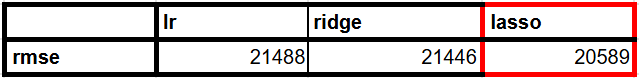


  Lasso model 선택

- 변수 설정 후 실험

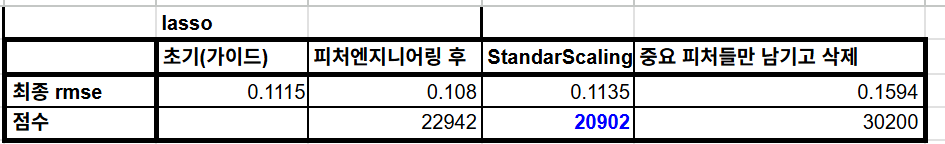

좌측 부터 순서대로 쓰여진대로 변수설정후 실험 진행 피처 엔지니어링 진행 후 Standard Scaling 한 실험이 가장 높았음
  
- 하이퍼 파라미터 튜닝

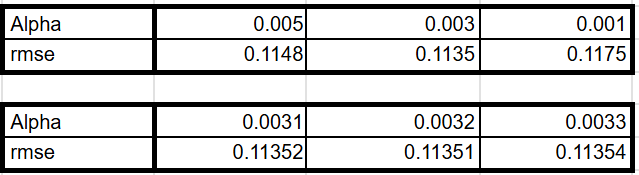

Lasso의 다른 파라미터들은 결과값 변화 X. 위 과정을 통해 0.0033이 최적임을 알았음


# 실험 결과 및 고찰

최종으로 submit한 결과는 20902로 저번 퀘스트에 비해 할만했다. 저번에는 너무 한가지에 매몰되서 거의 몇시간을 쏟아 부어서 제대로 끝내지 못했지만, 이번엔 안되는 건 과감히 버리고 빨리 빨리 결과를 내고자 했던것이 나아진 점 같다. 그리고 이번에도 가이드 코드들에 너무 매몰되어서 이미 만들어진 코드에 덮어서 고치고자 했지만 실력이 부족하여 처음부터 다시 했고, 모델의 성능을 더 끌어낼 여지가 있는 것 같긴 하여 더 고민을 해보아야 할 것 같다.


In [2]:
house_df['TotalSF'] = house_df['TotalBsmtSF'] + house_df['1stFlrSF'] + house_df['2ndFlrSF']    # 층 면적을 다 더한 총 집의 면적
house_df['TotalBath'] = house_df['FullBath'] + (0.5 * house_df['HalfBath']) + house_df['BsmtFullBath'] + (0.5 * house_df['BsmtHalfBath']) # 화장실 수수
house_df['HouseAge'] = house_df['YrSold'] - house_df['YearBuilt']           # 집의 연식
house_df['RemodAge'] = house_df['YrSold'] - house_df['YearRemodAdd']        # 리모델링 연식
house_df['IsRemodeled'] = (house_df['YearBuilt'] != house_df['YearRemodAdd'])     # 리모델링 여부


drop_col = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YrSold', 'YearBuilt', 'YearRemodAdd']

house_df.drop(drop_col, axis=1, inplace=True)

# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
# house_df.fillna(house_df.mean(),inplace=True)
num_cols = house_df.select_dtypes(include=['number']).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())


# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])


# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

house_df_ohe = pd.get_dummies(house_df)

cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)



## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

Null 컬럼과 그 건수:
  MasVnrType      694
GarageType       69
GarageFinish     69
GarageQual       69
GarageCond       69
BsmtExposure     24
BsmtFinType2     24
BsmtQual         23
BsmtCond         23
BsmtFinType1     23
Electrical        1
dtype: int64
get_dummies() 수행 전 데이터 Shape: (1168, 70)
get_dummies() 수행 후 데이터 Shape: (1168, 262)
## Null 피처의 Type :
 Series([], dtype: object)
MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.760540
OpenPorchSF       2.454159
MasVnrArea        2.418589
TotalSF  

In [14]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

scaler = StandardScaler()

X_train_processed = scaler.fit_transform(X_train)
X_test_processed = scaler.transform(X_test)

Lasso_model=Lasso(alpha = 0.0032) 


def rmse_cv(model,x_data, y_data):
    rmse= np.sqrt(-cross_val_score(model, x_data, y_data, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

rmse_cv(Lasso_model, X_train_processed, y_train).mean()

0.11351669008339878

In [4]:
Lasso_model.fit(X_train_processed, y_train)

pred_log_test = Lasso_model.predict(X_test_processed)
pred_orig_test = np.expm1(pred_log_test)
y_test_orig = np.expm1(y_test)

y_test_orig.mean()

171583.87606837606

In [5]:
## test_data를 받아오기
test = pd.read_csv('./house_test.csv')

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']    # 층 면적을 다 더한 총 집의 면적
test['TotalBath'] = test['FullBath'] + (0.5 * test['HalfBath']) + test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']) # 화장실 수수
test['HouseAge'] = test['YrSold'] - test['YearBuilt']           # 집의 연식
test['RemodAge'] = test['YrSold'] - test['YearRemodAdd']        # 리모델링 연식
test['IsRemodeled'] = (test['YearBuilt'] != test['YearRemodAdd'])     # 리모델링 여부


drop_col = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'YrSold', 'YearBuilt', 'YearRemodAdd']

test.drop(drop_col, axis=1, inplace=True)

num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape



(292, 261)

In [6]:
test_scaled = scaler.transform(test_ohe2)

In [7]:
## sample_data를 받아오기
sample = pd.read_csv('./sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [8]:
pred = Lasso_model.predict(test_scaled)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)